In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
physical_device = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [3]:
(x_train,_), (x_test,_) = tf.keras.datasets.mnist.load_data()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz: None -- [Errno 61] Connection refused

In [4]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

### 之前的维度变换代码

In [ ]:
# x_train = x_train.reshape(x_train.shape[0],-1) #变成60000 * 784的向量
# x_test = x_test.reshape(x_test.shape[0],-1)
# x_train.shape, x_test.shape

### 现在是增加一个维度作为通道信息

In [5]:
x_train = np.expand_dims(x_train, -1)#在最后一个维度加一个通道信息（如这个就是单通道的，维度就是1）
x_test = np.expand_dims(x_test, -1)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
#归一化像素值都是0-255的，归一化为0-1之间的数）
x_train = tf.cast(x_train, tf.float32) / 255
x_test = tf.cast(x_test, tf.float32) / 255

    tf.cast()函数的作用是执行 tensorflow 中张量数据类型转换，比如读入的图片如果是int8类型的，一般在要在训练前把图像的数据格式转换为float32。

### 增加噪声

In [7]:
#噪声系数
factor = 0.5
x_train_noise = x_train + factor * np.random.normal(0,1,size=x_train.shape) # 给x_train添加噪声x_train.shape:60000*784 
x_test_noise = x_test + factor * np.random.normal(0,1,size=x_test.shape) # 给x_train添加噪声x_test.shape:10000*784

x_train_noise = np.clip(x_train_noise,0.,1.)
x_test_noise = np.clip(x_test_noise,0.,1.)

print("x_train:",x_train.shape)
print("x_test:",x_test.shape)

print("x_train_noise:",x_train_noise.shape)
print("x_test_noise:",x_test_noise.shape)

x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)
x_train_noise: (60000, 28, 28, 1)
x_test_noise: (10000, 28, 28, 1)


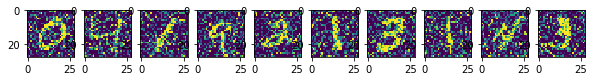

In [8]:
plt.figure(figsize=(10,2))
for i in range(1,11):#画10张图像，i从1到10
    ax = plt.subplot(1,10,i)
    plt.imshow(x_train_noise[i].reshape(28,28))

In [9]:
#之前的全连接的代码注释掉
# input_size = 784
# hidden_size = 32
# output_size = 784
# # input_dim = tf.keras.layers.Input(shape=(input_size,))

# #decode
# de = tf.keras.layers.Dense(output_size,activation='sigmoid')(en)
# model = tf.keras.Model(inputs=input_dim,outputs=de)

#encode：用卷积提取特征
# en = tf.keras.layers.Dense(hidden_size,activation='relu')(input_dim) #把input_dim传入这一层
input_dim = tf.keras.layers.Input(shape=x_train.shape[1:]) # x_train.shape[1:] 输出：TensorShape([28, 28, 1])
x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(input_dim) #28*28*16（16个3*3的卷积核）
x = tf.keras.layers.MaxPooling2D(padding='same')(x) #14*14*16（same就是保持原图大小不动，然后用2*2的池化窗口做池化）
x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x) #14*14*32（再用32个3*3的卷积核做卷积得到14*14*32）
x = tf.keras.layers.MaxPooling2D(padding='same')(x) #7*7*32

#decode：用反卷积上采样，还原回原来的图像
x = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same')(x)#stride就是把图像扩大回原来的2倍，把7*7*32的变成了14*14*16
x = tf.keras.layers.Conv2DTranspose(1, 3, strides=2, activation='sigmoid', padding='same')(x)#28*28*1

model = tf.keras.Model(inputs=input_dim,outputs=x)

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)        

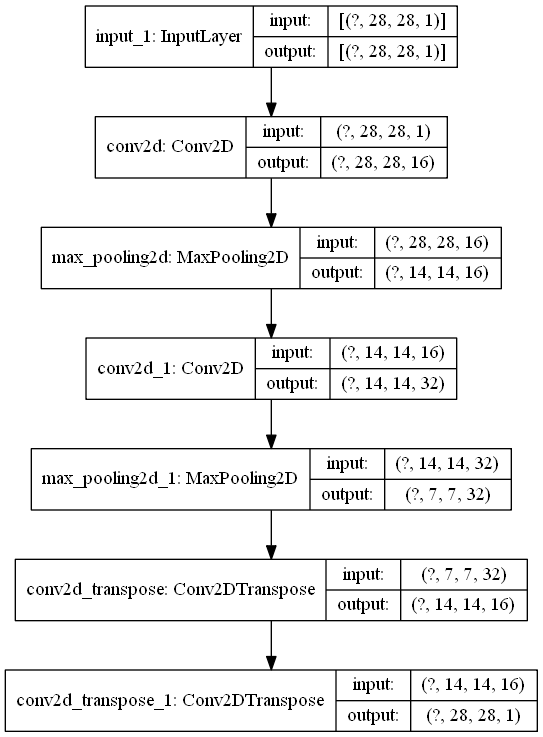

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mse')

In [13]:
#训练的时候用带噪声的图像，输出是去除噪声的
model.fit(x_train_noise,x_train,epochs=50,batch_size=256,shuffle=True,validation_data=(x_test_noise,x_test))

Epoch 1/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1048 - val_loss: 0.0437
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0300 - val_loss: 0.0225
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0211 - val_loss: 0.0195
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0191 - val_loss: 0.0180
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0171
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0165
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0156 - val_loss: 0.0152

In [14]:
pre_test = model.predict(x_test_noise)

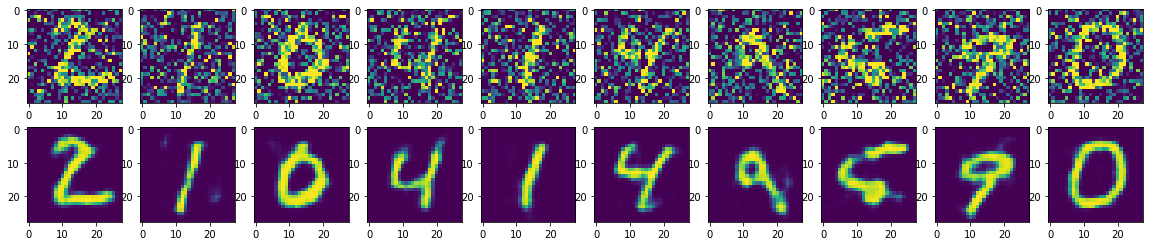

In [16]:
#画图
n = 10 #画两行10列的子图
plt.figure(figsize=(20,4))#宽20，高4
for i in range(1,11):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noise[i].reshape(28,28))
    ax = plt.subplot(2, n, n+i)
    plt.imshow(pre_test[i].reshape(28,28))